# phygnn-gan example

Here's a simple method for making a generative-adversarial network by using a binary classifier (adversary) in the custom loss function provided to the phygnn model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from rex import init_logger

from phygnn import PhysicsGuidedNeuralNetwork

In [2]:
init_logger('phygnn', log_level='INFO', log_file=None)

<Logger phygnn (INFO)>

In [3]:
def gan_loss(model, y_true, y_gen, p_data, adversary):
    """Guiding loss function for training a phygnn-GAN.
    
    Parameters
    ----------
    model : PhysicsGuidedNeuralNetwork
        Instance of the phygnn model (generative model) at the current 
        point in training.
    y_true : np.ndarray
        Placeholder, not actually used in GAN formulation.
    y_gen : tf.Tensor
        Generated data from the prediction of the generative model
    p : np.ndarray
        Supplemental feature data. In this case, the feature data is 
        passed in here. 
    adversary : tf.keras.Sequential
        Adversarial binary classification model.
    
    Returns
    -------
    generator_loss : tf.Tensor
        A 0D tensor loss value inversely proportional to the 
        adversary's classification error.
    """
    output_gen = tf.concat([p_data, y_gen], axis=1)
    labels_gen = tf.ones((len(y_gen), 1))
    classification = adversary(output_gen)
    adversary_error = tf.reduce_mean(tf.abs(labels_gen - classification))
    generator_loss = tf.constant(1, dtype=tf.float32) - adversary_error
    
    real_x0 = tf.random.uniform((len(y_gen), 2), minval=-10, maxval=10)
    real_x1 = (real_x0[:, 0] ** 2 + real_x0[:, 1] ** 2) ** 0.5
    real_x1 = tf.expand_dims(real_x1, axis=1)
    real_data = tf.concat([real_x0, real_x1], axis=1)
    labels_real = tf.zeros((len(real_data), 1))

    features = tf.concat([real_data, output_gen], axis=0)
    labels = tf.concat([labels_real, labels_gen], axis=0)

    adversary.fit(features, labels, 
                  batch_size=len(features), 
                  epochs=1, verbose=0)
    
    return generator_loss

In [4]:
adversary = keras.Sequential(
    [keras.Input(shape=(3)),
     layers.Dense(8, activation="relu", name="hidden1", kernel_initializer='he_uniform'),
     layers.Dense(8, activation="relu", name="hidden2", kernel_initializer='he_uniform'),
     layers.Dense(1, activation="sigmoid", name="output"),
    ]
)

adversary.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [5]:
hidden_layers = [{'units': 64, 'activation': 'relu'},
                 {'units': 64, 'activation': 'relu'},
                ]

generator = PhysicsGuidedNeuralNetwork(p_fun=gan_loss, 
                                       hidden_layers=hidden_layers,
                                       loss_weights=(0.0, 1.0), 
                                       learning_rate=0.001,
                                       n_features=2, n_labels=1,
                                       name='Generator')

In [6]:
n = 10000
features = np.random.random((n, 2)) * 20 - 10  # range from -10 to 10
dummy_labels = np.zeros((n, 1))
generator.fit(features, dummy_labels, features, n_batch=8, n_epoch=50, p_kwargs={'adversary': adversary})

INFO - 2021-02-02 16:34:48,520 [phygnn.py:773] : Epoch 0 train loss: 6.87e-01 val loss: 6.74e-01 for "Generator"
INFO - 2021-02-02 16:34:48,910 [phygnn.py:773] : Epoch 1 train loss: 4.95e-01 val loss: 4.58e-01 for "Generator"
INFO - 2021-02-02 16:34:49,386 [phygnn.py:773] : Epoch 2 train loss: 2.57e-01 val loss: 2.43e-01 for "Generator"
INFO - 2021-02-02 16:34:49,864 [phygnn.py:773] : Epoch 3 train loss: 2.14e-01 val loss: 2.03e-01 for "Generator"
INFO - 2021-02-02 16:34:50,244 [phygnn.py:773] : Epoch 4 train loss: 2.08e-01 val loss: 1.99e-01 for "Generator"
INFO - 2021-02-02 16:34:50,628 [phygnn.py:773] : Epoch 5 train loss: 2.12e-01 val loss: 2.04e-01 for "Generator"
INFO - 2021-02-02 16:34:51,040 [phygnn.py:773] : Epoch 6 train loss: 2.19e-01 val loss: 2.18e-01 for "Generator"
INFO - 2021-02-02 16:34:51,432 [phygnn.py:773] : Epoch 7 train loss: 2.72e-01 val loss: 2.73e-01 for "Generator"
INFO - 2021-02-02 16:34:51,983 [phygnn.py:773] : Epoch 8 train loss: 3.76e-01 val loss: 3.81e-01

<AxesSubplot:xlabel='epoch'>

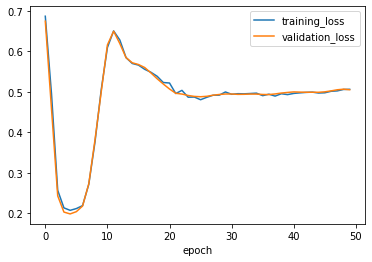

In [7]:
generator.history[['training_loss', 'validation_loss']].plot()

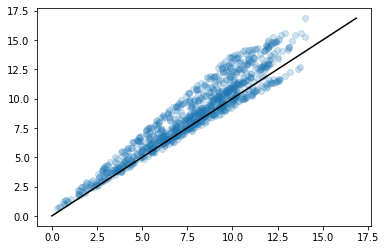

In [8]:
features = np.random.random((1000, 2)) * 20 - 10
generated = generator.predict(features)
plt.scatter((features[:, 0] ** 2 + features[:, 1] ** 2) ** 0.5, generated, alpha=0.2)
plt.plot([0, generated.max()], [0, generated.max()], c='k')